In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from circle_generator import Circles
from loss import SegmentationLoss, ImageLoss
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import tqdm
import matplotlib.pyplot as plt
import copy
import random

In [2]:
class ListModule(nn.Module):
    def __init__(self, *args):
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42)
        random.seed(42)
        np.random.seed(42)
        super(ListModule, self).__init__()
        idx = 0
        for module in args:
            self.add_module(str(idx), module)
            idx += 1

    def __getitem__(self, idx):
        if idx < 0 or idx >= len(self._modules):
            raise IndexError('index {} is out of range'.format(idx))
        it = iter(self._modules.values())
        for i in range(idx):
            next(it)
        return next(it)

    def __iter__(self):
        return iter(self._modules.values())

    def __len__(self):
        return len(self._modules)


class Autoencoder(nn.Module):
    
    def down_conv_module(self, num_input_channels, num_output_channels):
        module = nn.Sequential(
            nn.Conv2d(num_input_channels, num_output_channels, 3, padding=1),
            nn.BatchNorm2d(num_output_channels),
            nn.MaxPool2d(2)
        )
        return module
    
    def up_conv_module(self, num_input_channels, num_output_channels):
        
        module = nn.Sequential(
            nn.ConvTranspose2d(num_input_channels, num_output_channels, 4, stride=2, padding=1),
            nn.BatchNorm2d(num_output_channels)
        )
        return module
    
    def conv_module(self, num_input_channels, num_output_channels, kernel_size=3, padding=1):
        module = nn.Sequential(
            nn.Conv2d(num_input_channels, num_output_channels, kernel_size, padding=padding),
            nn.BatchNorm2d(num_output_channels)
        )
        return module
            
    def __init__(self, num_input_channels, num_classes):
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42)
        random.seed(42)
        np.random.seed(42)
        super(Autoencoder, self).__init__()
        down_modules = []
        output_channels = [32, 64, 128]
        input_channels = [num_input_channels, 32, 64]
        
        for in_channels, out_channels in zip(input_channels, output_channels):
            down_modules.append(self.down_conv_module(in_channels, out_channels))
            
        self.down_modules = ListModule(*down_modules)
            
        up_modules = []
        input_channels = [16, 32, 64]
        
        for in_channels, out_channels in zip(output_channels[::-1], input_channels[::-1]):
            up_modules.append(self.up_conv_module(in_channels, out_channels))
            
        self.up_modules = ListModule(*up_modules)
            
        self.conv_image = ListModule(*[self.conv_module(16, 8), self.conv_module(8, num_input_channels)])
        
        self.conv_segmentation = ListModule(*[self.conv_module(16, 8), self.conv_module(8, num_classes, 1, 0)])
        
    
    def forward(self, x):
        for module in self.down_modules:
            x = F.relu(module.forward(x))
        
        for module in self.up_modules:
            x = F.relu(module.forward(x))
        
        x_image = F.relu(self.conv_image[0].forward(x))
        x_image = F.tanh(self.conv_image[1].forward(x_image))
        
        x_segmentation = F.relu(self.conv_segmentation[0].forward(x))
        x_segmentation = self.conv_segmentation[1].forward(x_segmentation)
        
        return x_image, x_segmentation
    

In [3]:
predata = Circles(radius=12, bg_color=0, perim_color=0.2, circle_color=0.1,
                  size=(64, 64), n_obj=5, var_n_obj=1, var_size=5, maxover=0)

In [8]:
def generate_data(batch_sizes):
    np.random.seed(42)
    data = {}
    splits = ['train', 'val', 'test']
    for batch_size, split in zip(batch_sizes, splits):
        images, segmentation = predata.get_train_batch(batch_size)
        images = Variable(torch.from_numpy(images).float().cuda(0), requires_grad=False)
        segmentation = Variable(torch.from_numpy(segmentation).cuda(0), requires_grad=False)
        data[split] = (images, segmentation)
    return data

In [9]:
data = generate_data([128, 32, 16])

In [10]:
def train(data, net, number_without_segmentation, num_epoch, img_loss, segm_loss):
    train_loss_history = []
    val_loss_history = []
    
    last_update = 0
    best_val_score = None
    best_model_params = None
    
    optimizer = optim.Adam(net.parameters())
    
    for epoch in tqdm.tqdm(range(num_epoch)):
        net.train(True)
        optimizer.zero_grad()
        generated_images, generated_segmentation = net.forward(data['train'][0])
        
        if number_without_segmentation > 0:
            train_loss = segm_loss(generated_segmentation[:-number_without_segmentation], 
                                   data['train'][1][:-number_without_segmentation])
        else:
            train_loss = segm_loss(generated_segmentation, data['train'][1])
            
        train_loss += 1000*img_loss(generated_images, data['train'][0])
        train_loss_history.append(train_loss.data[0])
        
        train_loss.backward()
        optimizer.step()
        
        net.train(False)
        generated_val_images, generated_val_segmentation = net.forward(data['val'][0])
        val_loss = segm_loss(generated_val_segmentation, data['val'][1])
        val_loss += 1000*img_loss(generated_val_images, data['val'][0])
        val_loss_history.append(val_loss.data[0])
        
        if best_val_score is None or best_val_score > val_loss_history[-1]:
            best_val_score = val_loss_history[-1]
            best_model_params = copy.deepcopy(net.state_dict())
            last_update = 0
        else:
            last_update += 1

        
    #net.load_state_dict(best_model_params)
        #print('---- epoch {} -----'.format(epoch))
        #print('loss on train = {}'.format(train_loss_history[-1]))
        #print('loss on validation = {}'.format(val_loss_history[-1]))
        
    return train_loss_history, val_loss_history, best_model_params

In [11]:
def show_image_segm(gen_img, gen_segm, real_img, real_segm):
    for i, image in enumerate(gen_img):
        f, axarr = plt.subplots(2, 2, figsize=(10, 10))
        axarr[0, 0].imshow(image[0], cmap='gray')
        axarr[0, 0].set_title('Gen image')
        axarr[0, 1].imshow(real_img[i][0], cmap='gray')
        axarr[0, 1].set_title('Real image')
        axarr[1, 0].imshow(np.argmax(gen_segm[i], 0))
        axarr[1, 0].set_title('Gen segmentation')
        axarr[1, 1].imshow(real_segm[i])
        axarr[1, 1].set_title('Real segmentation')
    plt.show()

In [12]:
def test(net, data, segm_loss, img_loss):
    generated_images, generated_segmentation = net.forward(data['test'][0])

    segm_test_loss = segm_loss(generated_segmentation, data['test'][1]).data[0]
    l2_test_loss = img_loss(generated_images, data['test'][0]).data[0]
    #print('segmetation loss on test = {}'.format(segm_test_loss))
    #print('l2 loss on test = {}'.format(l2_test_loss))

    generated_images = generated_images.cpu().data.numpy()
    generated_segmentation = generated_segmentation.cpu().data.numpy()
    gt_images = data['test'][0].cpu().data.numpy()
    gt_segmentation = data['test'][1].cpu().data.numpy()

    #show_image_segm(generated_images, generated_segmentation, gt_images, gt_segmentation)
    return segm_test_loss, l2_test_loss

In [13]:
def compare_different_data(starting_parameters, net, data, num_without_segmentation, img_loss, segm_loss):
    torch.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    random.seed(42)
    np.random.seed(42)
    net.load_state_dict(starting_parameters)
    train_loss_history, val_loss_history, early_stopping_params = train(data, net, num_without_segmentation, 
                                                                        3000, img_loss, segm_loss)
    net.load_state_dict(early_stopping_params)
    
    #print('test results using unlabeled data')
    loss_with_unlabeled_data = test(net, data, segm_loss, img_loss)
    
    net.load_state_dict(starting_parameters)
    
    data_labeled = copy.deepcopy(data)
    data_labeled['train'] = (data['train'][0][:-num_without_segmentation], 
                             data['train'][1][:-num_without_segmentation])
    train_loss_history_segm, val_loss_history_segm, early_stopping_params = train(data_labeled, net, 0, 
                                                                        3000, img_loss, segm_loss)
    net.load_state_dict(early_stopping_params)
    
    #print('test results using only data with segmentation')
    loss_labeled_data = test(net, data, segm_loss, img_loss)
    
    plt.semilogy(train_loss_history, label='train', color='blue')
    plt.semilogy(val_loss_history, label='val', color='green')
    plt.semilogy(val_loss_history_segm, label='val, only labeled', color='red')
    plt.semilogy(train_loss_history_segm, label='train, only labeled', color='black')
    plt.legend()
    plt.show()
    return loss_with_unlabeled_data, loss_labeled_data

In [14]:
num_without_segmentation = 40
net = Autoencoder(num_input_channels=1, num_classes=3).cuda(0)
starting_parameters = copy.deepcopy(net.state_dict())
segm_loss = SegmentationLoss()
img_loss = ImageLoss()

100%|██████████| 3000/3000 [04:35<00:00, 10.88it/s]


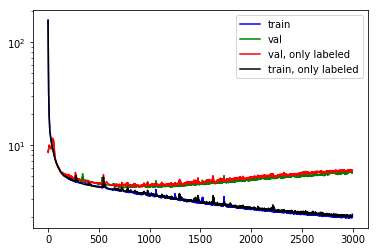

  0%|          | 0/3000 [00:00<?, ?it/s]

[0.003571312641724944]


100%|██████████| 3000/3000 [03:37<00:00, 13.77it/s]


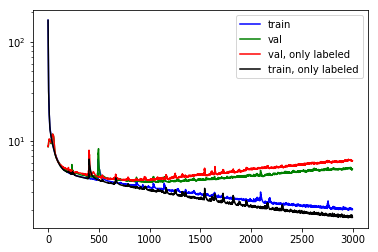

  0%|          | 1/3000 [00:00<05:03,  9.88it/s]

[0.003571312641724944, 0.0035230377689003944]


100%|██████████| 3000/3000 [02:55<00:00, 17.08it/s]


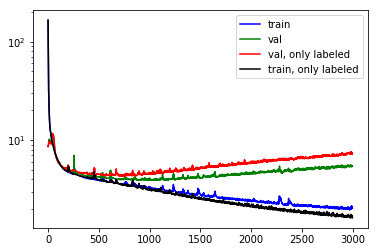

  0%|          | 1/3000 [00:00<05:00,  9.98it/s]

[0.003571312641724944, 0.0035230377689003944, 0.003643711330369115]


100%|██████████| 3000/3000 [02:05<00:00, 24.00it/s]


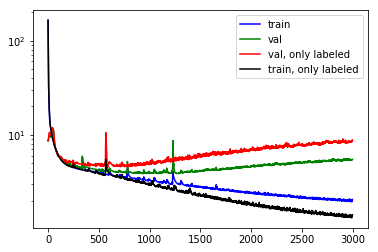

  0%|          | 2/3000 [00:00<04:52, 10.24it/s]

[0.003571312641724944, 0.0035230377689003944, 0.003643711330369115, 0.0035771250259131193]


100%|██████████| 3000/3000 [01:24<00:00, 35.39it/s]


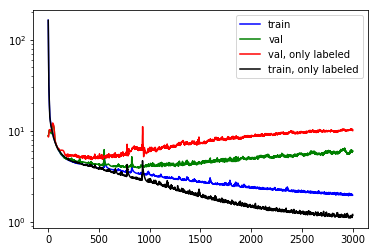

[0.003571312641724944, 0.0035230377689003944, 0.003643711330369115, 0.0035771250259131193, 0.003609494538977742]


In [12]:
numbers_without_segmentation = [10, 40, 60, 80, 100]

history_segm_loss_unlabeled = []
history_segm_loss_labeled = []
history_img_loss_unlabeled = []
history_img_loss_labeled = []

for num_without_segmentation in numbers_without_segmentation:
    unlabeled_loss, labeled_loss = compare_different_data(starting_parameters, net, data, 
                                                          num_without_segmentation, img_loss, segm_loss)
    history_segm_loss_unlabeled.append(unlabeled_loss[0])
    history_img_loss_unlabeled.append(unlabeled_loss[1])
    history_segm_loss_labeled.append(labeled_loss[0])
    history_img_loss_labeled.append(labeled_loss[1])
    

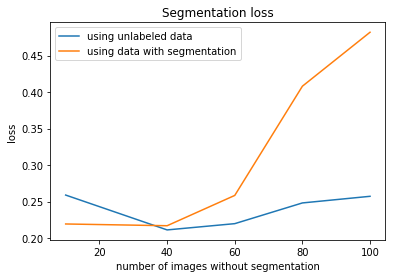

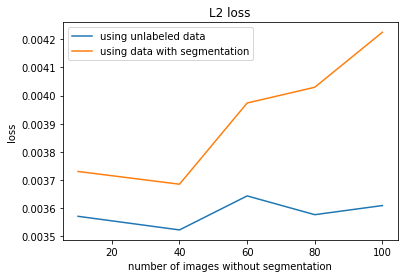

In [15]:
plt.plot(numbers_without_segmentation, history_segm_loss_unlabeled, label='using unlabeled data')
plt.plot(numbers_without_segmentation, history_segm_loss_labeled, label='using data with segmentation')
plt.title('Segmentation loss')
plt.xlabel('number of images without segmentation')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(numbers_without_segmentation, history_img_loss_unlabeled, label='using unlabeled data')
plt.plot(numbers_without_segmentation, history_img_loss_labeled, label='using data with segmentation')
plt.title('L2 loss')
plt.xlabel('number of images without segmentation')
plt.ylabel('loss')
plt.legend()
plt.show()

Now let's fix the amount of data with segmentation and just add different amount of unlabeled data.

In [20]:
data = generate_data([192, 32, 16])

100%|██████████| 3000/3000 [07:08<00:00,  7.01it/s]


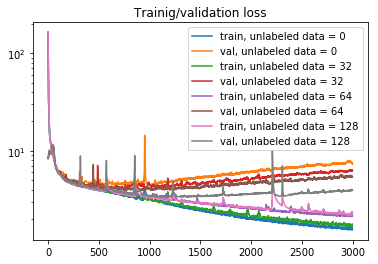

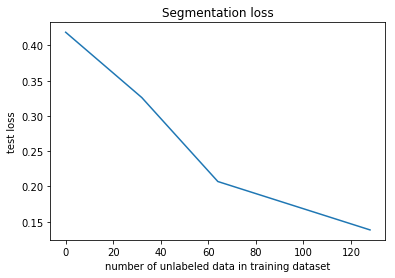

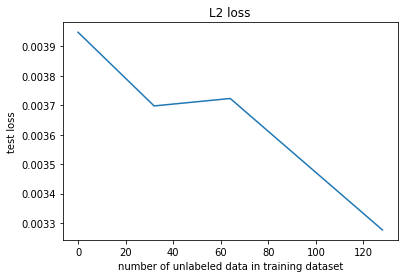

In [21]:
labeled_data_size = 64
unlabeled_data_sizes = [0, 32, 64, 128]

history_segm_loss = []
history_img_loss = []

for unlabeled_data_size in unlabeled_data_sizes:
    
    net.load_state_dict(starting_parameters)
    
    data_current = copy.deepcopy(data)
    data_current['train'] = (data['train'][0][:labeled_data_size + unlabeled_data_size], 
                             data['train'][1][:labeled_data_size + unlabeled_data_size])
    
    train_loss_history, val_loss_history, early_stopping_params = train(data_current, net, unlabeled_data_size, 
                                                                        3000, img_loss, segm_loss)
    
    plt.semilogy(train_loss_history, label='train, unlabeled data = {}'.format(unlabeled_data_size))
    plt.semilogy(val_loss_history, label='val, unlabeled data = {}'.format(unlabeled_data_size))
    
    net.load_state_dict(early_stopping_params)
    
    loss_test = test(net, data, segm_loss, img_loss)
    history_segm_loss.append(loss_test[0])
    history_img_loss.append(loss_test[1])
    
plt.title('Trainig/validation loss')
plt.legend()
plt.show()

plt.title('Segmentation loss')
plt.xlabel('number of unlabeled data in training dataset')
plt.ylabel('test loss')
plt.plot(unlabeled_data_sizes, history_segm_loss)
plt.show()

plt.title('L2 loss')
plt.xlabel('number of unlabeled data in training dataset')
plt.ylabel('test loss')
plt.plot(unlabeled_data_sizes, history_img_loss)
plt.show()